# 1.Importing Modules


In [100]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.activations import sigmoid
from keras.optimizers import Adam

# 2.Defining Batch Size, Image Dimensions, Channles And Epochs

In [30]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

# 3.Loading Dataset From Image Directory Into A Variable


In [31]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant_images",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

Found 2152 files belonging to 3 classes.


In [32]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1,
       1, 1, 2, 0, 2, 0, 1, 1, 0, 0])>>


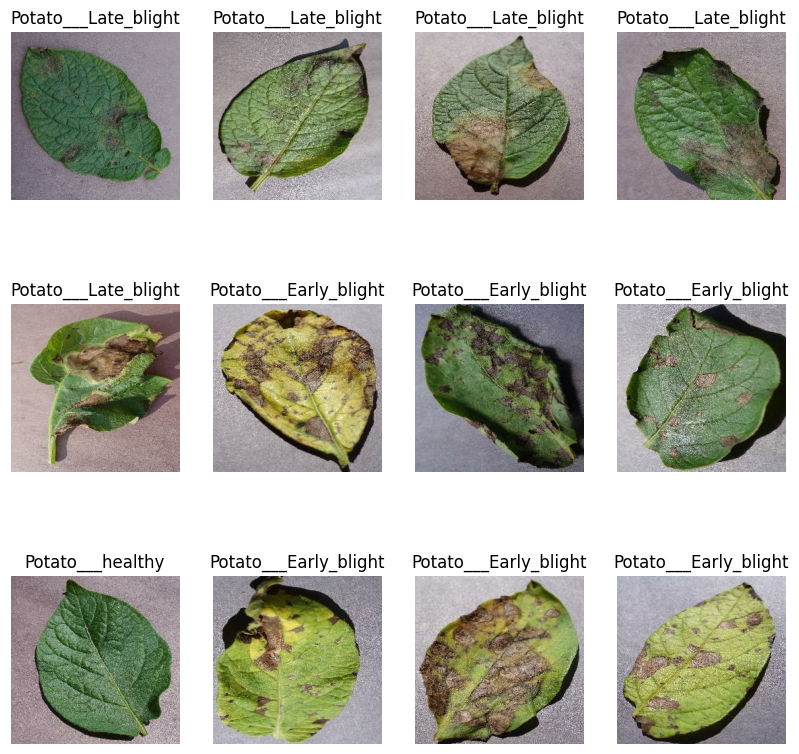

In [33]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy)
  for i in range(12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

# 4. Defining Size For Training Data, Test Data, Validation Data From The Main Dataset

In [34]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [35]:
train_ds = dataset.take(54)
len(train_ds)

54

In [36]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [37]:
val_size= 0.1
len(dataset)*val_size

6.800000000000001

In [38]:
val_ds = train_ds.take(6)
len(val_ds)

6

In [39]:
test_ds = test_ds.skip(6)
len(test_ds)

8

# 5. Function To Get The Data

In [40]:
def get_dataset_partition_tf(ds, train_split= 0.8, val_split=0.1, test_split=0.1, shuffle =True, shuffle_size = 10000):
  assert(train_split+test_split+val_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [42]:
print("Size Of Train Dataset is : ",len(train_ds))
print("Size Of validation Dataset is :",len(val_ds))
print("Size Of Test Dataset is :",len(test_ds))

Size Of Train Dataset is :  54
Size Of validation Dataset is : 6
Size Of Test Dataset is : 8


# 6. Preprocessing And Normalizing Data

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = t=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
for image_batch, labels_batch in dataset.take(1):
  print(image_batch[0].numpy()/255)

[[[0.5568628  0.54509807 0.5882353 ]
  [0.5176471  0.5058824  0.54901963]
  [0.49019608 0.47843137 0.52156866]
  ...
  [0.5019608  0.49411765 0.5372549 ]
  [0.5019608  0.49411765 0.5372549 ]
  [0.50980395 0.5019608  0.54509807]]

 [[0.5137255  0.5019608  0.54509807]
  [0.4862745  0.4745098  0.5176471 ]
  [0.4745098  0.4627451  0.5058824 ]
  ...
  [0.49411765 0.4862745  0.5294118 ]
  [0.5254902  0.5176471  0.56078434]
  [0.5647059  0.5568628  0.6       ]]

 [[0.50980395 0.49803922 0.5411765 ]
  [0.49411765 0.48235294 0.5254902 ]
  [0.49411765 0.48235294 0.5254902 ]
  ...
  [0.49411765 0.4862745  0.5294118 ]
  [0.5058824  0.49803922 0.5411765 ]
  [0.53333336 0.5254902  0.5686275 ]]

 ...

 [[0.7254902  0.7176471  0.7607843 ]
  [0.74509805 0.7372549  0.78039217]
  [0.7529412  0.74509805 0.7882353 ]
  ...
  [0.65882355 0.6509804  0.7019608 ]
  [0.65882355 0.6509804  0.7019608 ]
  [0.65882355 0.6509804  0.7019608 ]]

 [[0.7294118  0.72156864 0.7647059 ]
  [0.74509805 0.7372549  0.78039217]


In [45]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

In [46]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
]
)

# 7. Model Building

In [47]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [48]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

# 8. Model Compiling


In [102]:
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# 9. Model Trainig On Dataset

In [103]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 [==============================] - 78s 1s/step - loss: 0.0640 - accuracy: 0.9803 - val_loss: 0.0226 - val_accuracy: 0.9896
Epoch 2/50
54/54 [==============================] - 58s 1s/step - loss: 0.0233 - accuracy: 0.9925 - val_loss: 0.0869 - val_accuracy: 0.9844
Epoch 3/50
54/54 [==============================] - 56s 1s/step - loss: 0.0322 - accuracy: 0.9890 - val_loss: 0.1255 - val_accuracy: 0.9792
Epoch 4/50
54/54 [==============================] - 57s 1s/step - loss: 0.0347 - accuracy: 0.9873 - val_loss: 0.0399 - val_accuracy: 0.9844
Epoch 5/50
54/54 [==============================] - 56s 1s/step - loss: 0.0250 - accuracy: 0.9913 - val_loss: 0.1496 - val_accuracy: 0.9740
Epoch 6/50
54/54 [==============================] - 56s 1s/step - loss: 0.0240 - accuracy: 0.9936 - val_loss: 0.0873 - val_accuracy: 0.9844
Epoch 7/50
54/54 [==============================] - 56s 1s/step - loss: 0.0328 - accuracy: 0.9913 - val_loss: 0.0920 - val_accuracy: 0.9792
Epoch 8/50
54/54 [==

In [104]:
len(test_ds)

8

In [105]:
scores = model.evaluate(test_ds)
print(scores)

8/8 [==============================] - 5s 547ms/step - loss: 0.0371 - accuracy: 0.9883
[0.03713809326291084, 0.98828125]


In [106]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [107]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

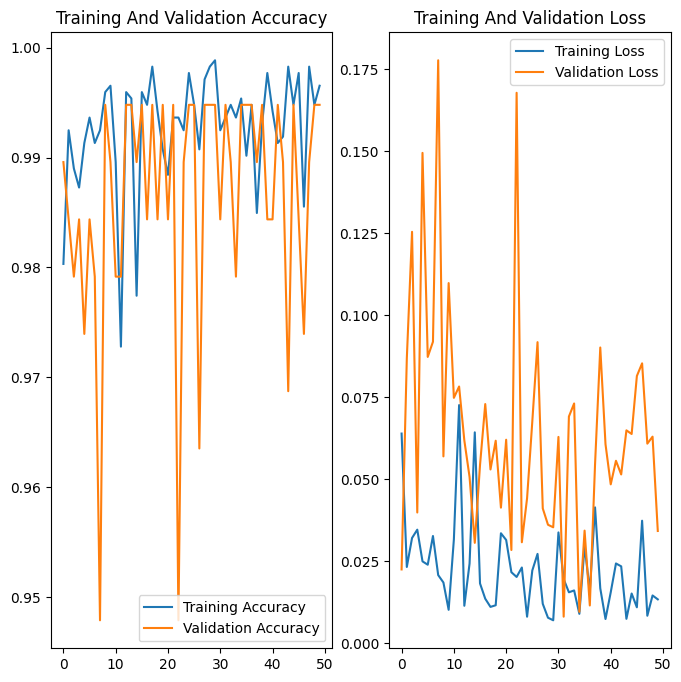

In [109]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS),acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training And Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training And Validation Loss")
plt.show()

First Image To Predict 
Actual Label:  Potato___Early_blight
1/1 [==============================] - 1s 984ms/step
Predicted Label : Potato___Early_blight


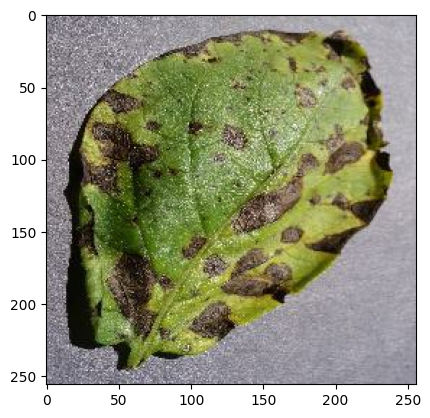

In [110]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")

    print("First Image To Predict ")
    plt.imshow(first_image)
    print("Actual Label: ",class_names[labels_batch[0].numpy()]) 


    batch_prediction = model.predict(images_batch)
    print("Predicted Label :",class_names[np.argmax(batch_prediction[0])])

In [111]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 87ms/step


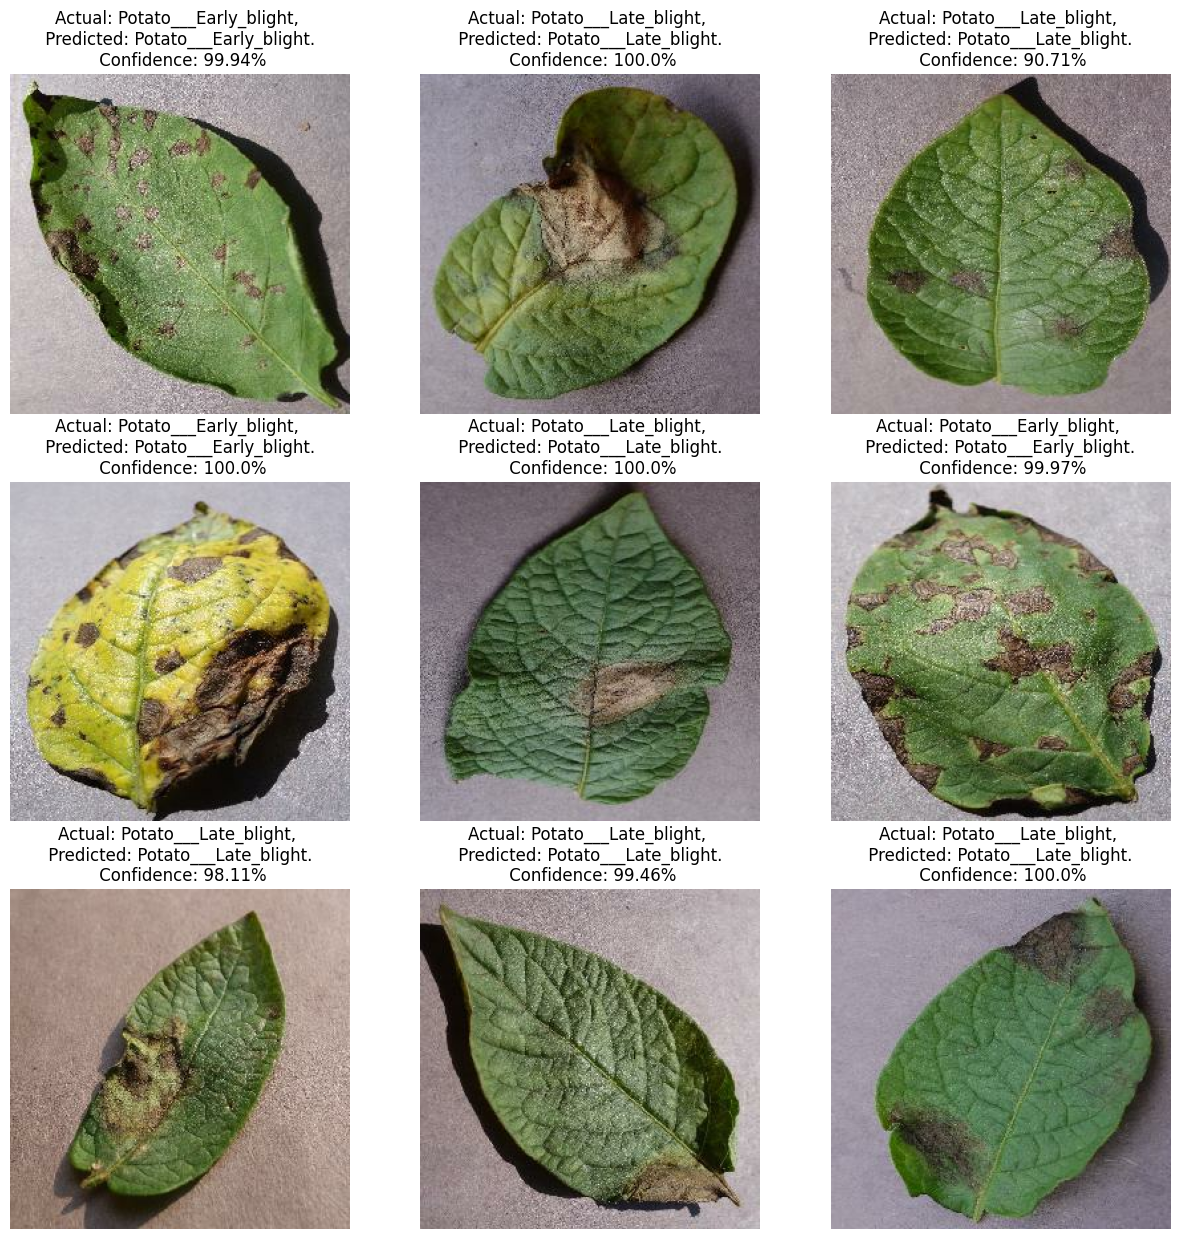

In [112]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3 , i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence  = predict(model, images[i].numpy())
    
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")

In [116]:
import os 
model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [113]:
model_version = 1


INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
